In [2]:
import pandas as pd
import requests
import numpy as np
import itertools
import talib
import quandl
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import time
import tushare as ts
from tensorflow.contrib.layers.python.layers.initializers import xavier_initializer
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Introduction
This is a tutorial of using reinforcement learning to do pairs trading

In [3]:
with open('sp500.csv','wb+') as f:
    response=requests.get('https://datahub.io/core/s-and-p-500-companies-financials/r/constituents-financials.csv')
    f.write(response.content)

In [4]:
sp500=pd.read_csv('sp500.csv')
sp500.index=sp500['Symbol']

In [27]:
# 由于只能获取现在的市值，所以股票的选取是涉嫌作弊的。
low_cap_company=sp500.loc[list(itertools.chain.from_iterable(list(map(lambda x:x[1][-3:],list(sp500.sort_values('Market Cap').groupby('Sector').groups.items())))))]

In [29]:
# 在每个行业选取市值最高的2只股票，获取数据，留下adj_close
quandl.ApiConfig.api_key = 'CTq2aKvtCkPPgR4L_NFs'
data=pd.DataFrame()
for s in low_cap_company['Symbol'].values:
    stock=quandl.get_table('WIKI/PRICES', date={'gte':'2005-01-01'}, ticker=s)
    stock.index=stock['date']
    data[s]=stock.adj_close

In [30]:
data=data.dropna(axis=1)
data.head()

,CMCSA,HD,AMZN,SLB,CVX,XOM,MON,GE,BA,D,...,AAPL,PFE,UNH,JNJ,CTL,VZ,T,WFC,BAC,JPM
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,9.221748,31.657186,44.52,26.117039,32.613076,35.833798,22.596144,23.539731,37.386798,20.471468,...,4.066824,15.611391,38.405571,43.206863,16.508052,19.509168,12.944909,21.611967,35.261361,27.877813
2005-01-04,8.986084,31.253208,42.14,25.917858,32.388821,35.590566,21.671663,23.256662,36.660627,20.377423,...,4.108591,15.611391,38.010962,43.069480,16.266124,19.311619,12.808328,21.629421,34.775626,27.592982
2005-01-05,9.070250,30.966750,41.77,25.999157,32.600262,35.404565,21.118625,23.115128,37.269437,20.234839,...,4.144574,15.505151,38.143976,43.042003,15.962528,19.282709,12.869031,21.653857,34.373376,27.650453
2005-01-06,9.056222,30.504012,41.05,26.507270,33.144881,35.855260,22.071033,23.301696,37.027380,20.344052,...,4.147787,15.516956,38.986398,43.165648,16.175994,19.241754,12.885471,21.730656,34.320249,27.808496
2005-01-07,9.137582,30.423216,42.32,25.824365,32.773258,35.619182,22.079315,23.160162,36.902684,20.298547,...,4.449795,15.522858,38.676032,43.007658,16.289843,19.173642,12.849607,21.702729,33.948357,27.585798


In [31]:
pd.DataFrame(data.columns,index=data.columns).join(sp500).groupby('Sector').count()['Symbol']

Sector
Consumer Discretionary        3
Consumer Staples              3
Energy                        3
Financials                    3
Health Care                   3
Industrials                   2
Information Technology        2
Materials                     1
Real Estate                   3
Telecommunication Services    3
Utilities                     3
Name: Symbol, dtype: int64

In [32]:
# 用一个SP500的连续期货合约来做baseline
sp500_baseline=quandl.get("CHRIS/CME_SP1")

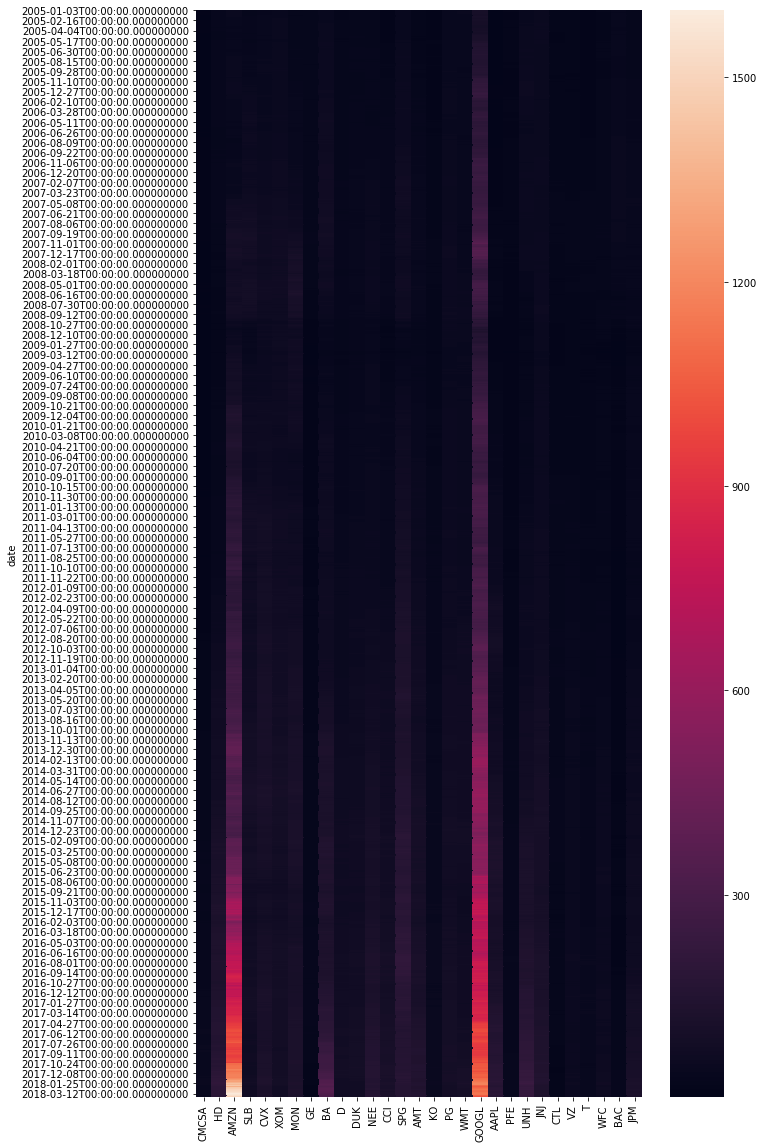

In [33]:
fig,ax=plt.subplots(figsize=(10,20))
sns.heatmap(data,ax=ax)

In [34]:
def generate_tech_data(stock):
    price=stock.values
    name=stock.name
    data=pd.DataFrame(stock)
    data[name+'_mom'] = talib.MOM(price)
    data[name+'_macd'], data[name+'_macd_sig'], data[name+'_macd_hist'] = talib.MACD(price)
    data[name+'_rsi'] = talib.RSI(price,timeperiod=10)
    data[name+'_cmo'] = talib.CMO(price)
    data=data.drop(name,axis=1)
    data=data.dropna()
    return data
z_score= lambda x:(x-x.mean(axis=0))/x.std(axis=0)

In [37]:
data.columns

Index(['CMCSA', 'HD', 'AMZN', 'SLB', 'CVX', 'XOM', 'MON', 'GE', 'BA', 'D',
       'DUK', 'NEE', 'CCI', 'SPG', 'AMT', 'KO', 'PG', 'WMT', 'GOOGL', 'AAPL',
       'PFE', 'UNH', 'JNJ', 'CTL', 'VZ', 'T', 'WFC', 'BAC', 'JPM'],
      dtype='object')

In [38]:
full_features=pd.concat(tuple([generate_tech_data(data[c]) for c in data.columns]),axis=1)

In [39]:
# 把所有数据准备好
diff=(data/data.shift(1))[full_features.index[0]:]
baseline_diff=(sp500_baseline['Last']/sp500_baseline['Last'].shift(1))[full_features.index[0]:]
log_diff=np.log(diff)[full_features.index[0]:]
price=data[full_features.index[0]:]
f_data=full_features.join(log_diff)
z_data=diff.join(pd.Series(np.ones((f_data.shape[0]))*1.0001,index=f_data.index,name='ASSET'))[full_features.index[0]:]
feature_number=f_data.shape[1]
asset_number=z_data.shape[1]
# tao=0.8
target_profit=2

In [40]:
class DRL_Portfolio(object):
    def __init__(self, feature_number, asset_number, dense_units_list=[1024, 768, 512, 256, 128], rnn_hidden_layer_number=4, rnn_hidden_units_number=128, learning_rate=0.001):
        tf.reset_default_graph()
        self.f = tf.placeholder(dtype=tf.float32, shape=[None, feature_number], name='environment_features')
        self.z = tf.placeholder(dtype=tf.float32, shape=[None, asset_number], name='environment_return')
        self.c = tf.placeholder(dtype=tf.float32, shape=[], name='environment_fee')
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32, shape=[], name='dropout_keep_prob')
        self.hidden_rnn_init_state = tf.placeholder(tf.float32, [rnn_hidden_layer_number, 1, rnn_hidden_units_number], name='hidden_rnn_initial_state')
        self.output_rnn_init_state = tf.placeholder(tf.float32, [1, asset_number], name='rnn_output_initial_state')
        self._state_per_layer_list = tf.unstack(self.hidden_rnn_init_state, axis=0) + [self.output_rnn_init_state]
        self.rnn_tuple_state = tuple(self._state_per_layer_list)
        self.last_rnn_output = tf.placeholder(dtype=tf.float32, shape=[1, asset_number], name='previous_rnn_output')
        
        with tf.variable_scope('feed_forward', initializer=tf.contrib.layers.xavier_initializer(uniform=False), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.dense_output = self._add_dense_layer(inputs=self.f, output_shape=dense_units_list[0], drop_keep_prob=self.dropout_keep_prob)
            for l in dense_units_list[1:]:
                self.dense_output = self._add_dense_layer(self.dense_output, output_shape=l, drop_keep_prob=self.dropout_keep_prob)
            self.dense_output = self._add_dense_layer(self.dense_output, output_shape=rnn_hidden_units_number, drop_keep_prob=self.dropout_keep_prob)
        
        with tf.variable_scope('rnn', initializer=tf.contrib.layers.xavier_initializer(uniform=False), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            rnn_hidden_cells = [self._add_gru_cell(rnn_hidden_units_number)] * rnn_hidden_layer_number
            rnn_output_cell = self._add_gru_cell(asset_number)
            layered_cell = tf.contrib.rnn.MultiRNNCell(rnn_hidden_cells + [rnn_output_cell])
            self.zero_state = layered_cell.zero_state(1, dtype=tf.float32)
            rnn_input = tf.expand_dims(self.dense_output, axis=0)
            self.rnn_outputs, self.current_state = tf.nn.dynamic_rnn(layered_cell, initial_state=self.rnn_tuple_state, inputs=rnn_input)
            self.current_output = tf.reshape(self.rnn_outputs[0][-1], shape=[1, asset_number])
            self.rnn_outputs = tf.concat((self.last_rnn_output, tf.unstack(self.rnn_outputs, axis=0)[0]), axis=0)
        with tf.variable_scope('action'):
            self.action = tf.nn.softmax(self.rnn_outputs)
        
        with tf.variable_scope('reward'):
            self.reward_t = tf.reduce_sum(self.z * self.action[:-1] - self.c * tf.abs(self.action[1:] - self.action[:-1]), axis=1)
            self.cum_reward = tf.reduce_prod(self.reward_t)
            self.log_reward = tf.reduce_sum(tf.log(self.reward_t))
        with tf.variable_scope('train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = optimizer.minimize(-self.log_reward)
        self.init_op = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        self.session = tf.Session()
    
    def init_model(self):
        self.session.run(self.init_op)
    
    def get_rnn_zero_state(self):
        zero_states = self.session.run([self.zero_state])[0]
        hidden_states = np.array(zero_states[:-1])
        output_state = zero_states[-1]
        return hidden_states, output_state
    
    def _add_dense_layer(self, inputs, output_shape, drop_keep_prob, act=tf.nn.tanh):
        output = tf.contrib.layers.fully_connected(activation_fn=act, num_outputs=output_shape, inputs=inputs)
        output = tf.nn.dropout(output, drop_keep_prob)
        return output
    
    def _add_gru_cell(self, units_number):
        return tf.contrib.rnn.GRUCell(num_units=units_number)
    
    def build_feed_dict(self, batch_F, batch_Z, keep_prob, fee, rnn_hidden_init_state, output_hidden_init_state, initial_output):
        return {
            self.f: batch_F,
            self.z: batch_Z,
            self.dropout_keep_prob: keep_prob,
            self.hidden_rnn_init_state: rnn_hidden_init_state,
            self.output_rnn_init_state: output_hidden_init_state,
            self.last_rnn_output: initial_output,
            self.c: fee
        }
    
    def train(self, feed):
        self.session.run([self.train_op], feed_dict=feed)
        
    def load_model(self, model_file='./trade_model_checkpoint/trade_model'):
        self.saver.restore(self.session,model_file)
    
    def save_model(self,model_path='./trade_model_checkpoint'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_file=model_path+'/trade_model'
        self.saver.save(self.session,model_file)
    
    def trade(self, feed):
        rewards, cum_reward, actions, current_state, current_rnn_output = self.session.run([self.reward_t, self.cum_reward, self.action, self.current_state, self.current_output], feed_dict=feed)
        hidden_current_states = np.array(current_state[:-1])
        output_current_state = current_state[-1]
        return rewards, cum_reward, actions, hidden_current_states, output_current_state, current_rnn_output

In [41]:
model=DRL_Portfolio(feature_number=feature_number,asset_number=asset_number)

In [42]:
def batch_nomorlize(f_data):
    need_normalize=f_data.columns[list(f_data.columns.map(lambda x:'_'in x))]
    keep_original=f_data.columns[list(f_data.columns.map(lambda x:'_'not in x))]
    return z_score(f_data[need_normalize]).join(f_data[keep_original])

In [54]:
model.init_model()
train_period=10
sequence_length=300
max_epoch=200
fee=1e-3
hidden_initial_state,output_initial_state=model.get_rnn_zero_state()
for e in range(max_epoch):
    train_actions=np.zeros((train_period*sequence_length,asset_number))
    train_reward=np.zeros(train_period*sequence_length)
    baseline=baseline_diff[:(train_period*sequence_length)]
    for batch in range(train_period):
        batch_f=batch_nomorlize(f_data[(batch*sequence_length):(batch+1)*sequence_length])
        batch_z=z_data[(batch*sequence_length):(batch+1)*sequence_length]
        
        feed=model.build_feed_dict(batch_F=batch_f,
                                   batch_Z=batch_z,
                                   keep_prob=0.8,
                                   fee=fee,
                                   rnn_hidden_init_state=hidden_initial_state,
                                   output_hidden_init_state=output_initial_state,
                                   initial_output=output_initial_state)
        model.train(feed)
        rewards, cum_reward, actions, hidden_initial_state, output_initial_state, current_rnn_output=model.trade(feed)
        train_reward[(batch*sequence_length):(batch+1)*sequence_length]=rewards.flatten()
        train_actions[(batch*sequence_length):(batch+1)*sequence_length]=actions[:-1]
    print("train_reward:", np.prod(train_reward))
    if np.prod(train_reward)>5*np.prod(baseline): break

train_reward: 6.600431510023697
train_reward: 7.1278919810303805
train_reward: 10.408321026083586


In [55]:
# model.init_model()
test_f=batch_nomorlize(f_data[sequence_length*train_period:])
test_z=z_data[sequence_length*train_period:]
hidden_initial_state,output_initial_state=model.get_rnn_zero_state()
feed=model.build_feed_dict(batch_F=test_f,
                               batch_Z=test_z,
                               keep_prob=1.0,
                               fee=fee,
                               rnn_hidden_init_state=hidden_initial_state,
                               output_hidden_init_state=output_initial_state,
                               initial_output=output_initial_state)
rewards, cum_reward, actions, hidden_current_states, output_current_state, current_rnn_output = model.trade(feed=feed)
print(cum_reward)

1.1203618


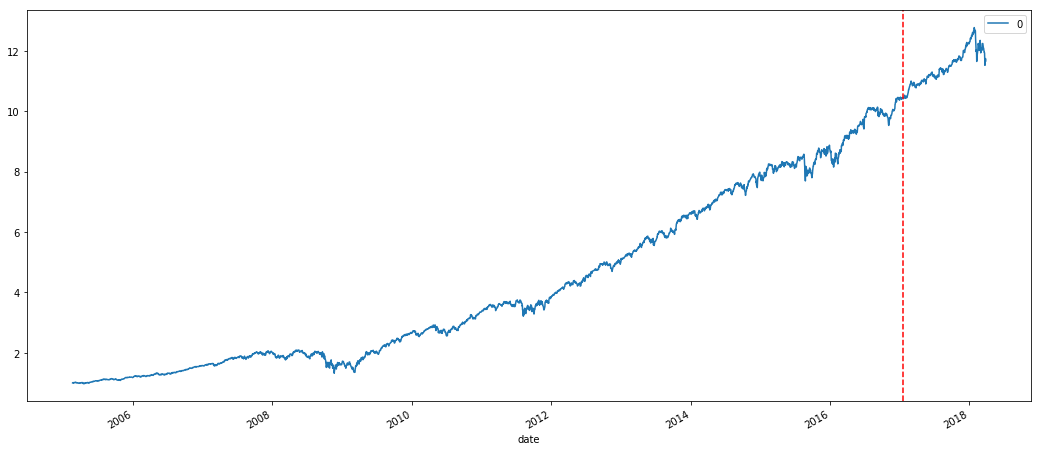

In [59]:
pd.DataFrame(np.concatenate((train_reward,rewards)),index=f_data.index).cumprod().plot(figsize=(18,8))
plt.axvline(z_data[:train_period*sequence_length].index[-1],color='red',linestyle='--')
# The test result of 300 days seems OK,keeps the uptrend

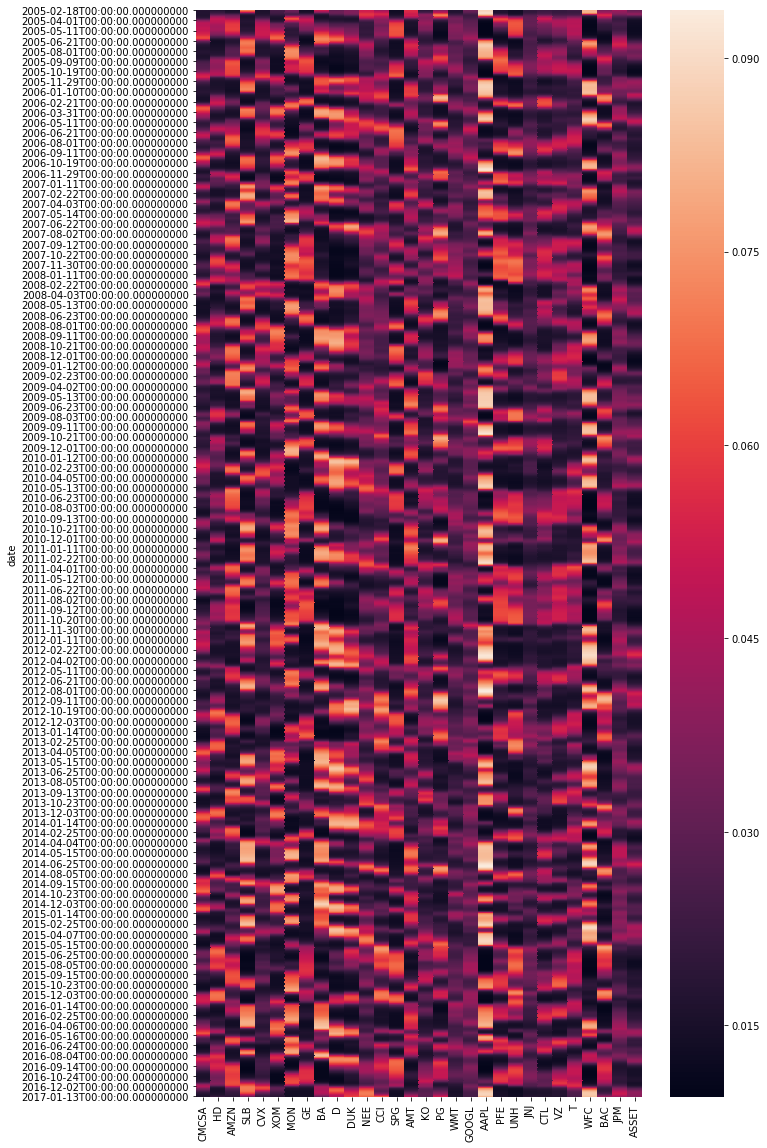

In [65]:
# lets see how the agent acts

fig,ax=plt.subplots(figsize=(10,20))
sns.heatmap(pd.DataFrame(train_actions,index=z_data[:train_period*sequence_length].index,columns=z_data.columns),ax=ax)

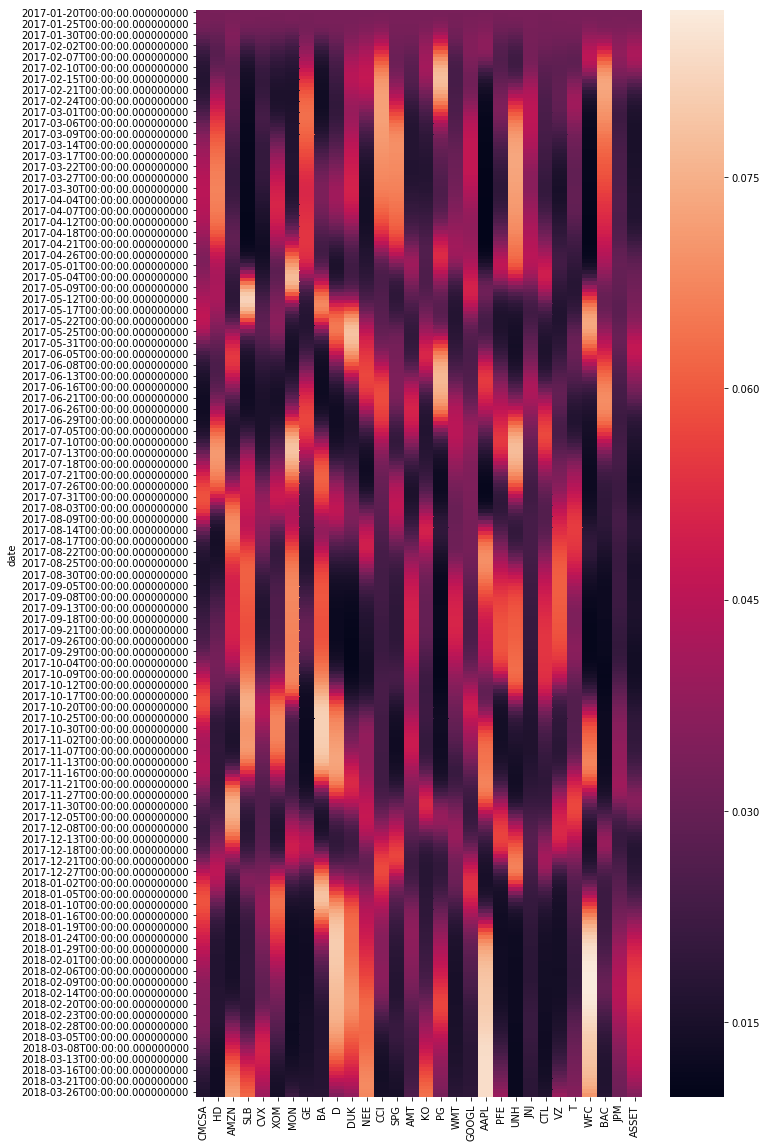

In [63]:
# lets see how the agent actsb

fig,ax=plt.subplots(figsize=(10,20))
sns.heatmap(pd.DataFrame(actions[:-1],index=z_data[train_period*sequence_length:].index,columns=z_data.columns),ax=ax)

## Thanks for your support 😏